In [2]:
import os
from dotenv import load_dotenv
load_dotenv()

import requests
import pandas as pd
import json


In [3]:
#interest rate
fred_api_key = os.getenv("FRED_API_KEY")
url = f"https://api.stlouisfed.org/fred/series/observations?series_id=FEDFUNDS&api_key={fred_api_key}&file_type=json"
response = requests.get(url)
data = response.json()

#I'll convert the dictionary to a json file so we see what's in there
print(json.dumps(data, sort_keys=True)[:1000])

#the date and value columns are the only ones we care about...
interest_rates = pd.DataFrame(data["observations"])[["date", "value"]]

print(interest_rates.head())
print(interest_rates.dtypes)

#need to convert the types:
interest_rates["date"] = pd.to_datetime(interest_rates["date"])
interest_rates["value"] = pd.to_numeric(interest_rates["value"], errors="coerce")

print(interest_rates.isna().any(axis=1).sum())


{"count": 835, "file_type": "json", "limit": 100000, "observation_end": "9999-12-31", "observation_start": "1600-01-01", "observations": [{"date": "1954-07-01", "realtime_end": "2024-02-18", "realtime_start": "2024-02-18", "value": "0.80"}, {"date": "1954-08-01", "realtime_end": "2024-02-18", "realtime_start": "2024-02-18", "value": "1.22"}, {"date": "1954-09-01", "realtime_end": "2024-02-18", "realtime_start": "2024-02-18", "value": "1.07"}, {"date": "1954-10-01", "realtime_end": "2024-02-18", "realtime_start": "2024-02-18", "value": "0.85"}, {"date": "1954-11-01", "realtime_end": "2024-02-18", "realtime_start": "2024-02-18", "value": "0.83"}, {"date": "1954-12-01", "realtime_end": "2024-02-18", "realtime_start": "2024-02-18", "value": "1.28"}, {"date": "1955-01-01", "realtime_end": "2024-02-18", "realtime_start": "2024-02-18", "value": "1.39"}, {"date": "1955-02-01", "realtime_end": "2024-02-18", "realtime_start": "2024-02-18", "value": "1.29"}, {"date": "1955-03-01", "realtime_end":

In [4]:
#BLS - CPI
bls_api_key = os.getenv("BLS_API_KEY")

url = "https://api.bls.gov/publicAPI/v2/timeseries/data/"
#cap of 20 years so I'll do 2 requests
payload1 = {
    "seriesid": ["CUUR0000SA0"],
    "startyear": "1996",
    "endyear": "2010",
    "registrationkey": bls_api_key,
}

response1 = requests.post(url, json=payload1)
data1 = response1.json()
print(json.dumps(data1)[:1000])

payload2 = {
    "seriesid": ["CUUR0000SA0"],
    "startyear": "2011",
    "endyear": "2023",
    "registrationkey": bls_api_key,
}

response2 = requests.post(url, json=payload2)
data2 = response2.json()
print(json.dumps(data2)[:1000])


{"status": "REQUEST_SUCCEEDED", "responseTime": 214, "message": [], "Results": {"series": [{"seriesID": "CUUR0000SA0", "data": [{"year": "2010", "period": "M12", "periodName": "December", "value": "219.179", "footnotes": [{}]}, {"year": "2010", "period": "M11", "periodName": "November", "value": "218.803", "footnotes": [{}]}, {"year": "2010", "period": "M10", "periodName": "October", "value": "218.711", "footnotes": [{}]}, {"year": "2010", "period": "M09", "periodName": "September", "value": "218.439", "footnotes": [{}]}, {"year": "2010", "period": "M08", "periodName": "August", "value": "218.312", "footnotes": [{}]}, {"year": "2010", "period": "M07", "periodName": "July", "value": "218.011", "footnotes": [{}]}, {"year": "2010", "period": "M06", "periodName": "June", "value": "217.965", "footnotes": [{}]}, {"year": "2010", "period": "M05", "periodName": "May", "value": "218.178", "footnotes": [{}]}, {"year": "2010", "period": "M04", "periodName": "April", "value": "218.009", "footnotes

In [5]:
#I'll now create two dataframes and combine them

df1_data = []
for data in data1["Results"]["series"][0]["data"]:
        df1_data.append({"month": data["periodName"], "year": data["year"], "value": data["value"]})

df2_data = []
for data in data2["Results"]["series"][0]["data"]:
        df2_data.append({"month": data["periodName"], "year": data["year"], "value": data["value"]})

df1 = pd.DataFrame(df1_data)
df2 = pd.DataFrame(df2_data)
cpi_u = pd.concat([df1, df2], ignore_index=True)

cpi_u.sort_values(by="year", inplace=True) #sorting by year

print(cpi_u.head())
print(cpi_u.tail())




         month  year  value
168   December  1996  158.6
170    October  1996  158.3
171  September  1996  157.8
172     August  1996  157.3
173       July  1996  157.0
         month  year    value
183  September  2023  307.789
182    October  2023  307.671
181   November  2023  307.051
180   December  2023  306.746
186       June  2023  305.109


In [6]:
#need to calculate inflation rate
cpi_u["value"] = pd.to_numeric(cpi_u["value"], errors = "coerce")
cpi_u["inflation"] = ((cpi_u["value"] - cpi_u.groupby("month")["value"].shift(1)) / cpi_u.groupby("month")["value"].shift(1)) * 100

#i also want to have a datetime object in case i want to visualize this with the interest rate data:

cpi_u["date"] = pd.to_datetime(cpi_u["year"].astype(str) + " " + cpi_u["month"] + "1")



In [7]:
print(cpi_u.head(20))
print(cpi_u.tail())

         month  year  value  inflation       date
168   December  1996  158.6        NaN 1996-12-01
170    October  1996  158.3        NaN 1996-10-01
171  September  1996  157.8        NaN 1996-09-01
172     August  1996  157.3        NaN 1996-08-01
173       July  1996  157.0        NaN 1996-07-01
174       June  1996  156.7        NaN 1996-06-01
169   November  1996  158.6        NaN 1996-11-01
176      April  1996  156.3        NaN 1996-04-01
177      March  1996  155.7        NaN 1996-03-01
178   February  1996  154.9        NaN 1996-02-01
179    January  1996  154.4        NaN 1996-01-01
175        May  1996  156.6        NaN 1996-05-01
156   December  1997  161.3   1.702396 1997-12-01
165      March  1997  160.0   2.761721 1997-03-01
164      April  1997  160.2   2.495202 1997-04-01
163        May  1997  160.1   2.234994 1997-05-01
162       June  1997  160.3   2.297384 1997-06-01
161       July  1997  160.5   2.229299 1997-07-01
160     August  1997  160.8   2.225048 1997-08-01


In [8]:
#now BLS - unemployment

#BLS
url = "https://api.bls.gov/publicAPI/v2/timeseries/data/"
#cap of 20 years so I'll do 2 requests
payload1 = {
    "seriesid": ["LNS14000000"],
    "startyear": "1996",
    "endyear": "2010",
    "registrationkey": bls_api_key,
}

response1 = requests.post(url, json=payload1)
data1 = response1.json()
print(json.dumps(data1)[:1000])

payload2 = {
    "seriesid": ["LNS14000000"],
    "startyear": "2011",
    "endyear": "2023",
    "registrationkey": bls_api_key,
}

response2 = requests.post(url, json=payload2)
data2 = response2.json()
print(json.dumps(data2)[:1000])




{"status": "REQUEST_SUCCEEDED", "responseTime": 228, "message": [], "Results": {"series": [{"seriesID": "LNS14000000", "data": [{"year": "2010", "period": "M12", "periodName": "December", "value": "9.3", "footnotes": [{}]}, {"year": "2010", "period": "M11", "periodName": "November", "value": "9.8", "footnotes": [{}]}, {"year": "2010", "period": "M10", "periodName": "October", "value": "9.4", "footnotes": [{}]}, {"year": "2010", "period": "M09", "periodName": "September", "value": "9.5", "footnotes": [{}]}, {"year": "2010", "period": "M08", "periodName": "August", "value": "9.5", "footnotes": [{}]}, {"year": "2010", "period": "M07", "periodName": "July", "value": "9.4", "footnotes": [{}]}, {"year": "2010", "period": "M06", "periodName": "June", "value": "9.4", "footnotes": [{}]}, {"year": "2010", "period": "M05", "periodName": "May", "value": "9.6", "footnotes": [{}]}, {"year": "2010", "period": "M04", "periodName": "April", "value": "9.9", "footnotes": [{}]}, {"year": "2010", "period":

In [9]:
#I'll now create two dataframes and combine them

df1_data = []
for data in data1["Results"]["series"][0]["data"]:
        df1_data.append({"month": data["periodName"], "year": data["year"], "value": data["value"]})

df2_data = []
for data in data2["Results"]["series"][0]["data"]:
        df2_data.append({"month": data["periodName"], "year": data["year"], "value": data["value"]})

df1 = pd.DataFrame(df1_data)
df2 = pd.DataFrame(df2_data)
unemp = pd.concat([df1, df2], ignore_index=True)

unemp["date"] = pd.to_datetime(unemp["year"].astype(str) + " " + unemp["month"] + "1")

unemp.sort_values(by="date", inplace=True) #sorting by year
print(unemp.head())
print(unemp.tail())

        month  year value       date
179   January  1996   5.6 1996-01-01
178  February  1996   5.5 1996-02-01
177     March  1996   5.5 1996-03-01
176     April  1996   5.6 1996-04-01
175       May  1996   5.6 1996-05-01
         month  year value       date
184     August  2023   3.8 2023-08-01
183  September  2023   3.8 2023-09-01
182    October  2023   3.8 2023-10-01
181   November  2023   3.7 2023-11-01
180   December  2023   3.7 2023-12-01


In [10]:
#now i want to combine the key values of the dataframes. This requires renaming the value columns first...

interest_rates_subset = interest_rates[["date", "value"]].rename(columns={"value": "interest_rate"})
cpi_u_subset = cpi_u[["date", "inflation"]].rename(columns={"inflation": "inflation_rate"})
unemp_subset = unemp[["date", "value"]].rename(columns={"value": "unemployment_rate"})

df_merged = interest_rates_subset.merge(cpi_u_subset, on="date", how="outer").merge(unemp_subset, on="date", how="outer") #start with interest_rates, add cpi_u then unemp 


In [11]:
#now let's subset only the last 25 years
start_date = "1998-01-01" 
end_date = "2023-12-01" 

last_25= df_merged[(df_merged["date"] >= start_date) & (df_merged["date"] <= end_date)] 
last_25.reset_index(drop=True, inplace=True)

print(last_25.head())
print(last_25.tail())

        date  interest_rate  inflation_rate unemployment_rate
0 1998-01-01           5.56        1.571339               4.6
1 1998-02-01           5.51        1.441103               4.6
2 1998-03-01           5.49        1.375000               4.7
3 1998-04-01           5.45        1.435705               4.3
4 1998-05-01           5.49        1.686446               4.4
          date  interest_rate  inflation_rate unemployment_rate
307 2023-08-01           5.33        3.665112               3.8
308 2023-09-01           5.33        3.699698               3.8
309 2023-10-01           5.33        3.241145               3.8
310 2023-11-01           5.33        3.137271               3.7
311 2023-12-01           5.33        3.352123               3.7


In [12]:
#SMOOTHING
last_25["date"] = pd.to_datetime(last_25["date"])

# Using a rolling average for smoothing...window will be 3 
last_25["inflation_rate_smooth"] = last_25["inflation_rate"].rolling(window=3, center=True).mean()
last_25["interest_rate_smooth"] = last_25["interest_rate"].rolling(window=3, center=True).mean()
last_25["unemployment_rate_smooth"] = last_25["unemployment_rate"].rolling(window=3, center=True).mean()

# Removing any NaNs
last_25.dropna(subset=["inflation_rate_smooth", "interest_rate_smooth", "unemployment_rate_smooth"], inplace=True)


/var/folders/28/xsh6qgd908q5ng87yxcxs6300000gn/T/ipykernel_62894/4249939512.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last_25["date"] = pd.to_datetime(last_25["date"])
/var/folders/28/xsh6qgd908q5ng87yxcxs6300000gn/T/ipykernel_62894/4249939512.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last_25["inflation_rate_smooth"] = last_25["inflation_rate"].rolling(window=3, center=True).mean()
/var/folders/28/xsh6qgd908q5ng87yxcxs6300000gn/T/ipykernel_62894/4249939512.py:6: SettingWithCopyWarning: 


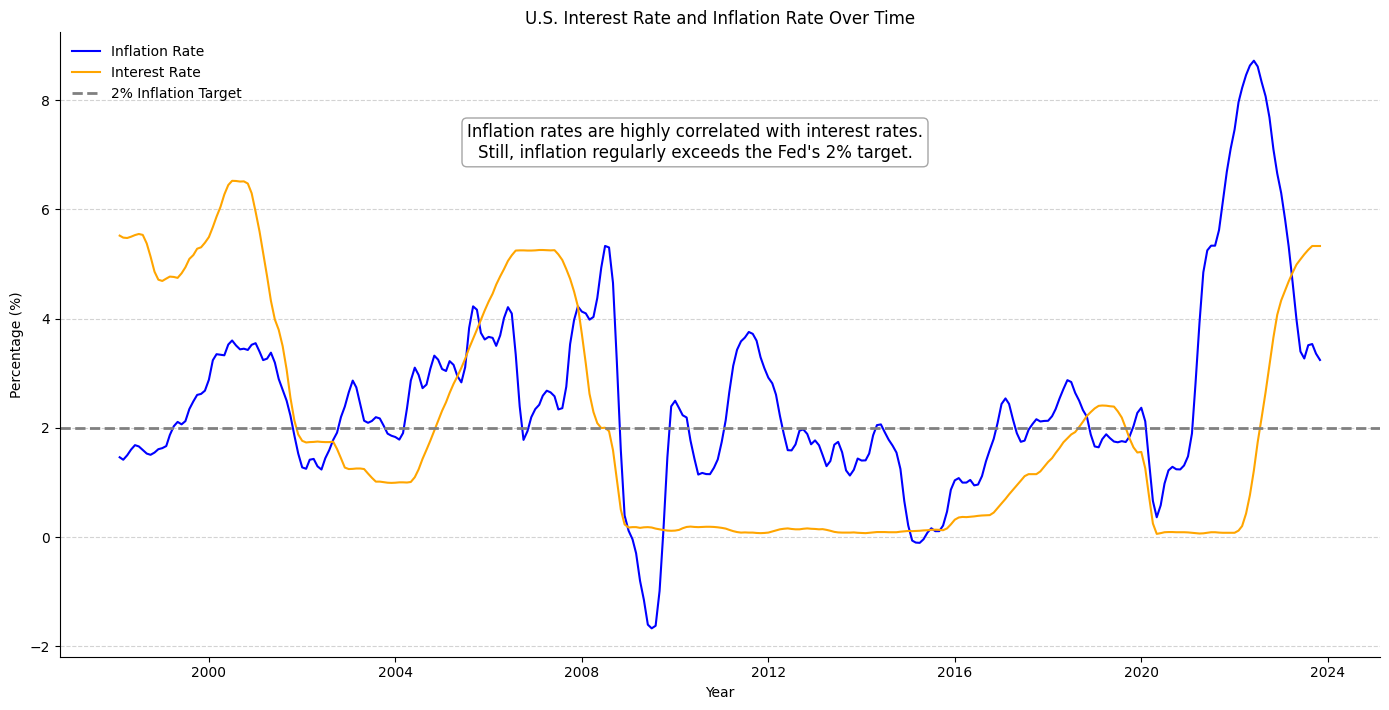

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(14, 8))

sns.lineplot(data=last_25, x="date", y="inflation_rate_smooth", color="blue", label= "Inflation Rate")
sns.lineplot(data=last_25, x="date", y="interest_rate_smooth", color="orange", label= "Interest Rate")

# Adding dashed line for 2% inflation target 
plt.axhline(y=2, color="gray", linestyle="--", linewidth=2, label="2% Inflation Target")

#Labels + title 
plt.xlabel("Year")
plt.ylabel("Percentage (%)")
plt.title("U.S. Interest Rate and Inflation Rate Over Time")

#Text box - failure to hit 2%
textstr = "Inflation rates are highly correlated with interest rates.\nStill, inflation regularly exceeds the Fed's 2% target."
plt.figtext(0.5, 0.8, textstr, wrap=True, horizontalalignment="center", fontsize=12,
            bbox=dict(boxstyle="round", facecolor="white", edgecolor="gray", alpha=0.7))

plt.tight_layout(rect=[0, 0.1, 1, 1])

plt.legend(frameon=False) #get rid of frame

plt.gca().yaxis.grid(True, linestyle="--", color="lightgrey")  # Wilke: only horizantal lines...and light
plt.gca().xaxis.grid(False) 

#clean up - remove top/right spines
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.show()


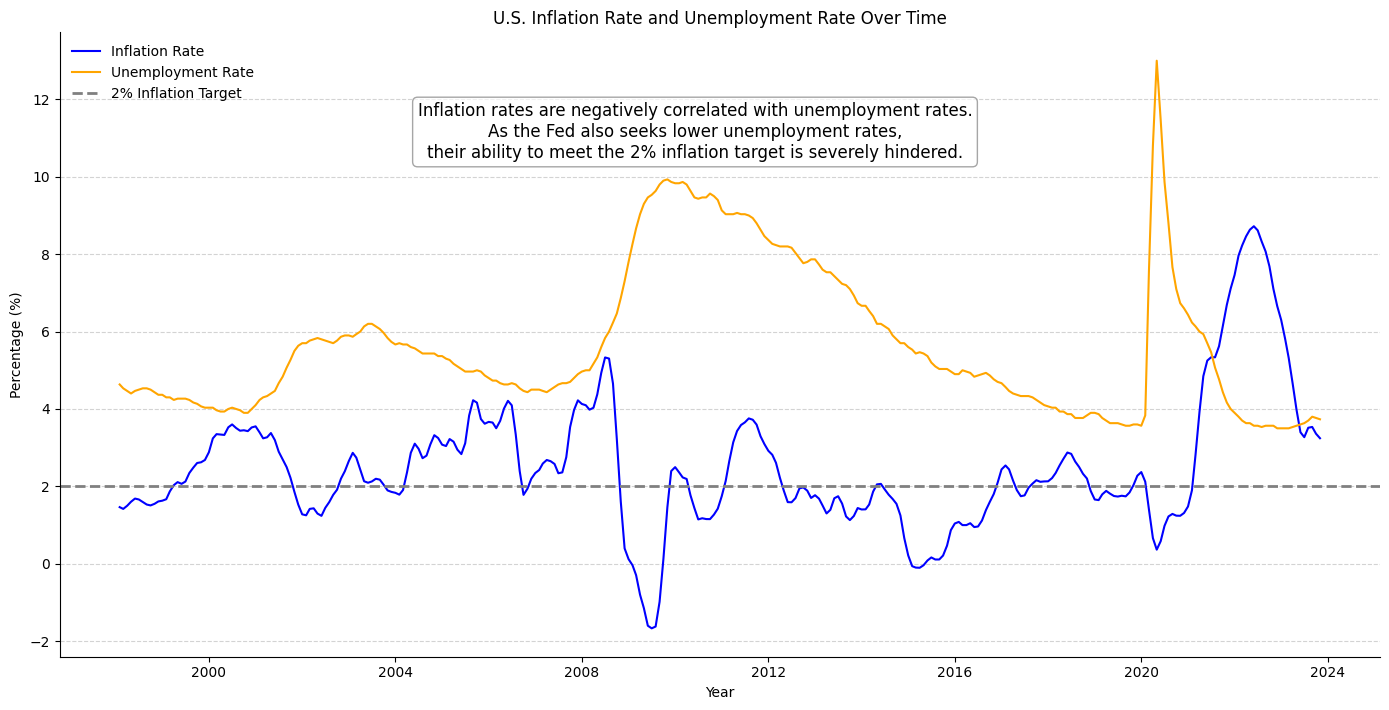

In [14]:
#now I'll do inflation vs. unemployment...staying as consistent as possible.

plt.figure(figsize=(14, 8))

sns.lineplot(data=last_25, x="date", y="inflation_rate_smooth", color="blue", label="Inflation Rate")
sns.lineplot(data=last_25, x="date", y="unemployment_rate_smooth", color="orange", label="Unemployment Rate")

plt.axhline(y=2, color="gray", linestyle="--", linewidth=2, label="2% Inflation Target") #It's borderline but worth keeping I think 

plt.xlabel("Year")
plt.ylabel("Percentage (%)")
plt.title("U.S. Inflation Rate and Unemployment Rate Over Time")

# Text box - highlight inverse correlation--complication of hitting inflation targets
textstr = "Inflation rates are negatively correlated with unemployment rates.\nAs the Fed also seeks lower unemployment rates,\ntheir ability to meet the 2% inflation target is severely hindered."
plt.figtext(0.5, 0.8, textstr, wrap=True, horizontalalignment="center", fontsize=12,
            bbox=dict(boxstyle="round", facecolor="white", edgecolor="gray", alpha=0.7))

plt.tight_layout(rect=[0, 0.1, 1, 1])
plt.legend(frameon=False, loc = "upper left")

#grid lines again
plt.gca().yaxis.grid(True, linestyle="--", color="lightgrey")  
plt.gca().xaxis.grid(False) 

plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)

plt.show()